In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import category_encoders as ce

from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

https://www.kaggle.com/code/sharanharsoor/ctr-analysis-of-different-ml-models#conclusion


In [223]:
data = pd.read_csv("train.csv", chunksize=10 ** 7)

In [224]:
chunk_size = 10 ** 7
num_of_chunk = 0
train = pd.DataFrame()

for chunk in pd.read_csv('train.csv', chunksize=chunk_size):
    num_of_chunk = num_of_chunk + 1
    train = pd.concat([train, chunk.sample(frac=0.01)], axis=0, ignore_index=True)
    print(f'NUMBER {str(num_of_chunk)} is done.')

NUMBER 1 is done.
NUMBER 2 is done.
NUMBER 3 is done.
NUMBER 4 is done.
NUMBER 5 is done.


In [225]:
train['hour'] = pd.to_datetime(train['hour'], format='%y%m%d%H')

In [226]:
train['month'] = train['hour'].dt.month
train['dayofweek'] = train['hour'].dt.dayofweek
train['day'] = train['hour'].dt.day
train['hour_time'] = train['hour'].dt.hour

In [227]:
col = ['C15', 'C16', 'C19', 'C21']

for col in col:
    percentiles = train[col].quantile(0.98)
    if train[col].quantile(0.98) < 0.5 * train[col].max():
        train[col][train[col] >= percentiles] = percentiles

/var/folders/64/q9vthv094_591jd1jlz91_x00000gn/T/ipykernel_82939/716951613.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col][train[col] >= percentiles] = percentiles
/var/folders/64/q9vthv094_591jd1jlz91_x00000gn/T/ipykernel_82939/716951613.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col][train[col] >= percentiles] = percentiles


In [228]:
numerical = []
categorical = []

for col in train.columns:
    if train[col].dtype == "object":
        categorical.append(col)
    else:
        numerical.append(col)
print("numerical columns = ",numerical)
print("categorical columns = ",categorical)

numerical columns =  ['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'month', 'dayofweek', 'day', 'hour_time']
categorical columns =  ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


0    0.829986
1    0.170014
Name: click, dtype: float64


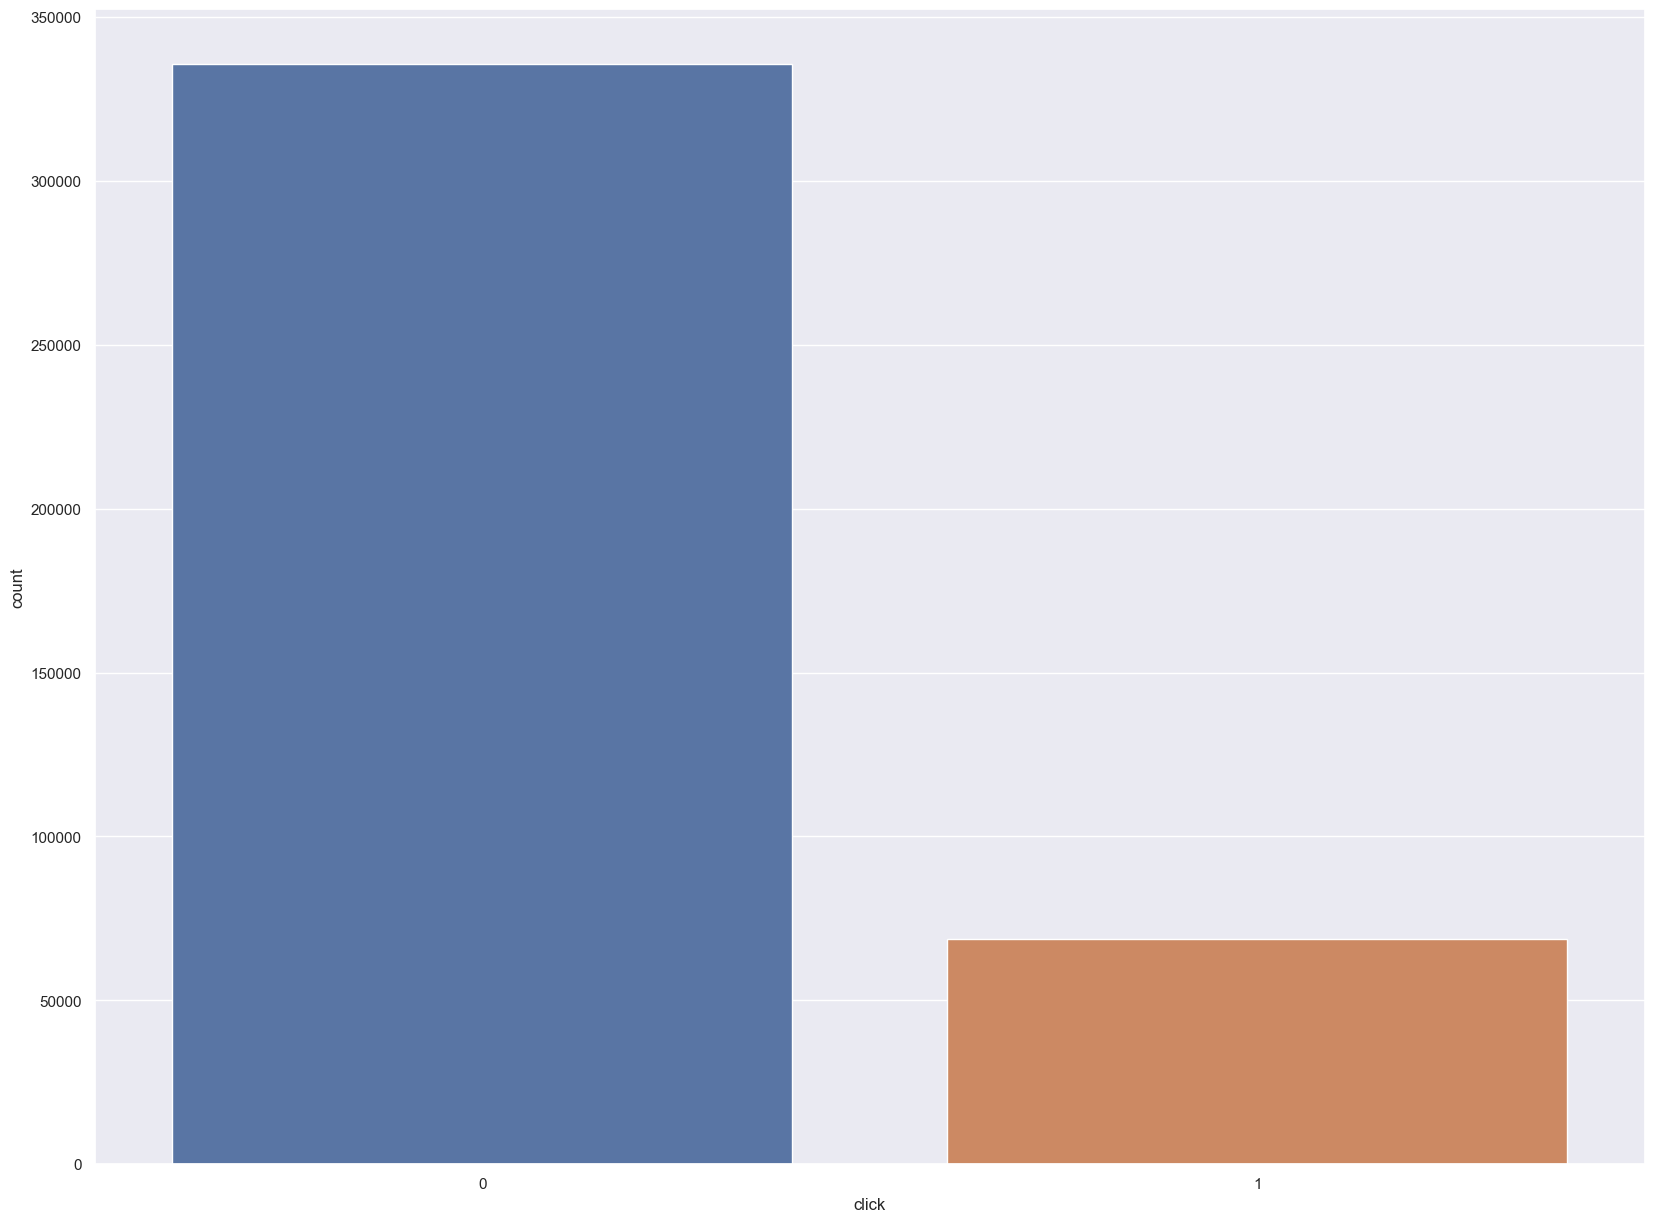

In [229]:
print(train.click.value_counts(normalize = True))
plt.figure()
sns.countplot(x='click', data=train)
plt.show()

In [230]:
train.drop(['month', 'C20'], axis=1, inplace=True)

In [231]:
train.drop(['hour'], axis = 1, inplace = True)
train.rename(columns={'click': 'y',
                      'hour_time': 'hour'},
             inplace=True, errors='raise')

train.columns

Index(['id', 'y', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C21', 'dayofweek', 'day', 'hour'],
      dtype='object')

In [232]:
sampled_data = train.sample(frac=0.1, random_state=42)
X = sampled_data.drop(['y'], axis=1)
y = sampled_data['y']

In [233]:
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)

In [234]:
def eval_model(model, _X_test, _y_test):
    _y_pred = model.predict(_X_test)
    _accuracy = metrics.accuracy_score(_y_test, _y_pred)
    _cnf_matrix = metrics.confusion_matrix(_y_test, _y_pred)

    return _accuracy, -cnf_matrix

In [235]:
def draw_roc(model, _X_test, _actual):
    _probs = model.predict(_X_test)
    fpr, tpr, thresholds = metrics.roc_curve(_actual, _probs, drop_intermediate=False)
    auc_score = metrics.roc_auc_score(_actual, _probs)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

In [236]:
from sklearn.model_selection import cross_val_score


def cross_val(model, _x, _y, _folds):
    cross_validation = cross_val_score(model, _x, _y, cv=_folds, n_jobs=-1)
    return cross_validation

In [237]:
random_sample = RandomOverSampler()
x_new, y_new = random_sample.fit_resample(X, y)

In [238]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size=0.3, random_state= 42)

In [239]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = X_train.copy()
X_train_scaled[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train_scaled.head()

,id,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
53519,0.999522,0.363636,0.142857,0.498370,0.427684,0.602077,0.553451,0.646678,0.766965,0.103044,...,0.948156,1.0,0.130435,0.958412,0.666667,0.001107,0.086614,0.166667,0.777778,0.478261
20332,0.308897,0.363636,0.142857,0.498370,0.427684,0.602077,0.553451,0.646678,0.766965,0.103044,...,0.919719,1.0,0.130435,0.921739,0.000000,0.284607,0.196850,0.500000,0.222222,0.739130
29425,0.398646,0.363636,0.000000,0.286750,0.287489,0.998247,0.553451,0.646678,0.766965,0.103044,...,0.844087,1.0,0.130435,0.839698,0.000000,0.003322,0.614173,0.333333,0.111111,0.391304
23015,0.083311,0.363636,0.142857,0.498370,0.427684,0.602077,0.553451,0.646678,0.766965,0.103044,...,0.182195,1.0,0.130435,0.117580,0.666667,0.003322,0.122047,1.000000,0.555556,0.565217
31236,0.018494,0.363636,0.000000,0.346965,0.347642,0.714008,0.553451,0.646678,0.766965,0.103044,...,0.647864,1.0,0.130435,0.608696,0.000000,0.001107,0.307087,0.166667,0.777778,0.782609


0.9829582153326377
[[-7451 -2563]
 [-1129 -8884]]


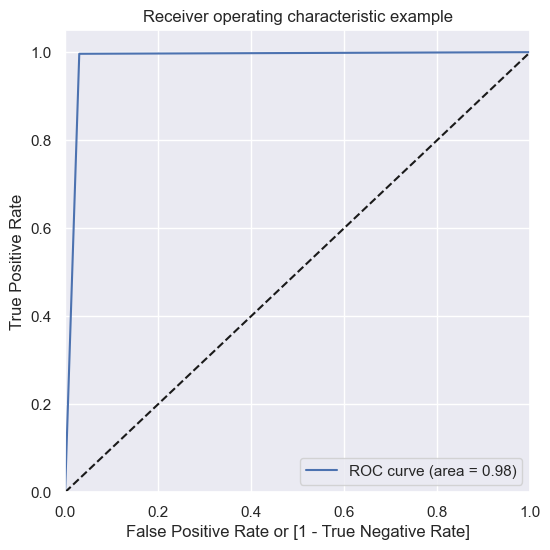

(array([0.        , 0.03040541, 1.        ]),
 array([0.        , 0.99632316, 1.        ]),
 array([2, 1, 0]))

In [240]:
from sklearn.tree import DecisionTreeClassifier

dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_train, y_train)
y_preds = dt_basic.predict(X_test)
accuracy, cnf_matrix = eval_model(dt_basic, X_test, y_test)
print(accuracy)
print(cnf_matrix)
draw_roc(dt_basic, X_test, y_test)

In [241]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)

0.9829582153326377
[[7451 2563]
 [1129 8884]]


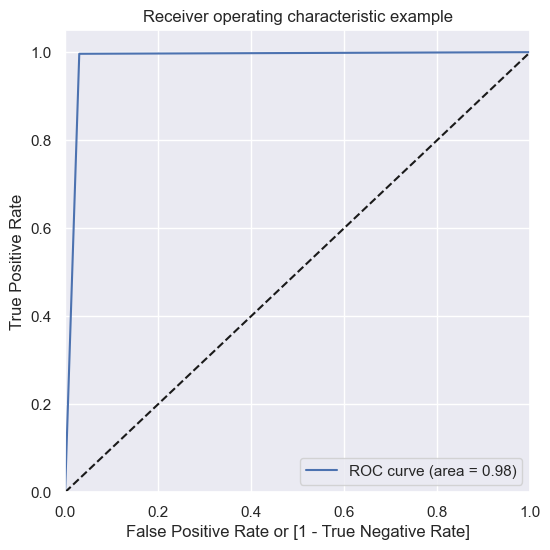

(array([0.        , 0.03040541, 1.        ]),
 array([0.        , 0.99632316, 1.        ]),
 array([2, 1, 0]))

In [242]:
dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_train, y_train)
y_preds = dt_basic.predict(X_test)
accuracy, cnf_matrix = eval_model(dt_basic, X_test, y_test)
print(accuracy)
print(cnf_matrix)
draw_roc(dt_basic, X_test, y_test)

0.9815670492373428
[[-7451 -2563]
 [-1129 -8884]]


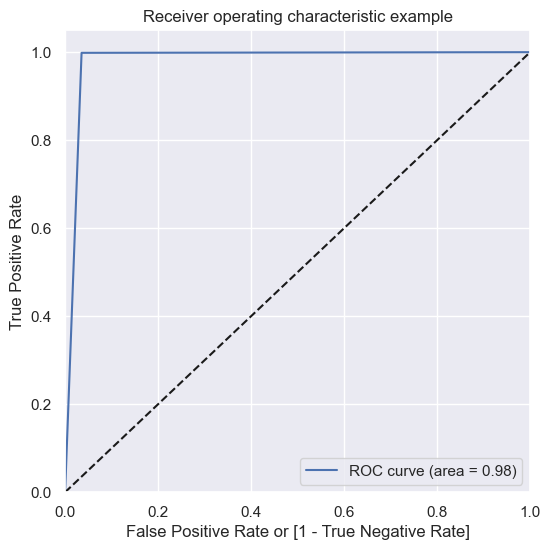

(array([0.        , 0.03537361, 1.        ]),
 array([0.        , 0.99850939, 1.        ]),
 array([2, 1, 0]))

In [243]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_preds = model_rf.predict(X_test)
accuracy, cnf_matrix = eval_model(model_rf, X_test, y_test)
print(accuracy)
print(cnf_matrix)
draw_roc(model_rf, X_test, y_test)

In [244]:
data_feature = sampled_data.copy()

In [245]:
data_feature.drop(['C14', 'C1'], axis=1, inplace=True)

In [246]:
X = data_feature.drop(['y'], axis=1)
y = data_feature['y']

In [247]:
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)

In [248]:
random_sample = RandomOverSampler()
x_new, y_new = random_sample.fit_resample(X, y)

In [249]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)

In [250]:
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head()

,id,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,...,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
53519,0.797257,0.000000,0.354721,0.355390,0.602077,0.553451,0.646678,0.766965,0.103044,0.883723,...,0.0,1.0,0.130435,0.973913,0.333333,0.000000,0.830709,0.166667,0.777778,0.565217
20332,0.308897,0.142857,0.498370,0.427684,0.602077,0.553451,0.646678,0.766965,0.103044,0.402292,...,0.0,1.0,0.130435,0.921739,0.000000,0.284607,0.196850,0.500000,0.222222,0.739130
29425,0.398646,0.000000,0.286750,0.287489,0.998247,0.553451,0.646678,0.766965,0.103044,0.402292,...,0.0,1.0,0.130435,0.839698,0.000000,0.003322,0.614173,0.333333,0.111111,0.391304
23015,0.083311,0.142857,0.498370,0.427684,0.602077,0.553451,0.646678,0.766965,0.103044,0.883723,...,0.0,1.0,0.130435,0.117580,0.666667,0.003322,0.122047,1.000000,0.555556,0.565217
31236,0.018494,0.000000,0.346965,0.347642,0.714008,0.553451,0.646678,0.766965,0.103044,0.575749,...,0.0,1.0,0.130435,0.608696,0.000000,0.001107,0.307087,0.166667,0.777778,0.782609


In [251]:
dt_tree = DecisionTreeClassifier(random_state=42)
dt_tree.fit(X_train, y_train)
feature_importances = dt_tree.feature_importances_
features = X_train.columns
df = pd.DataFrame({'features': features, 'importance': feature_importances})
df.sort_values(by='importance', ascending = False)

,features,importance
9,device_ip,0.880363
0,id,0.025423
10,device_model,0.018004
21,hour,0.014636
8,device_id,0.013323
15,C17,0.008209
3,site_domain,0.008065
20,day,0.007924
19,dayofweek,0.006468
17,C19,0.005050


In [252]:
df = df[df.importance > 0.02]
rf_cols = []
for col in list(X_train.columns):
    if col in list(df.features):
        rf_cols.append(col)

In [253]:
dt_tree = DecisionTreeClassifier(random_state=42)
dt_tree.fit(X_train[rf_cols], y_train)

DecisionTreeClassifier(random_state=42)

(46963, 2) (46963,)
2
(46963, 2) (46963,)
Train results
accuracy 1.0
cnf_matrix 
 [[7451 2563]
 [1129 8884]]
Test results
accuracy 0.9796293536046107
cnf_matrix 
 [[-7451 -2563]
 [-1129 -8884]]


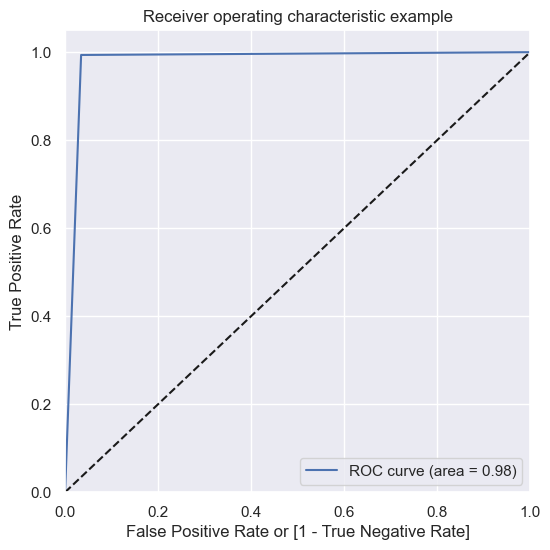

(array([0.        , 0.03437997, 1.        ]),
 array([0.        , 0.99364007, 1.        ]),
 array([2, 1, 0]))

In [254]:
print(X_train[rf_cols].shape, y_train.shape)
X_train = X_train[rf_cols].copy()
X_test[X_test.columns] = scaler.transform(X_test)
X_test = X_test[rf_cols]

print(len(rf_cols))
print(X_train.shape, y_train.shape)

predict_rf = dt_tree.predict(X_train)
predict_rf_test = dt_tree.predict(X_test)

accuracy, cnf_matrix = eval_model(dt_tree, X_train, y_train)
print("Train results")
print("accuracy",accuracy)
print("cnf_matrix \n",cnf_matrix)

accuracy, cnf_matrix = eval_model(dt_tree, X_test, y_test)
print("Test results")
print("accuracy",accuracy)
print("cnf_matrix \n",cnf_matrix)

draw_roc(dt_tree, X_test, y_test)

['id', 'device_ip']
2
Train results
accuracy 1.0
cnf_matrix 
 [[7451 2563]
 [1129 8884]]
Test results
accuracy 0.9793312465841904
cnf_matrix 
 [[-7451 -2563]
 [-1129 -8884]]


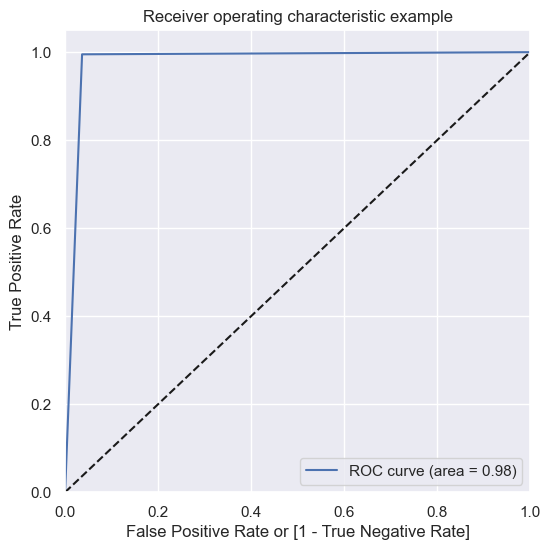

(array([0.        , 0.03646661, 1.        ]),
 array([0.        , 0.99513068, 1.        ]),
 array([2, 1, 0]))

In [255]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
print(rf_cols)

print(len(rf_cols))
predict_rf = model_rf.predict(X_train)
predict_rf_test = model_rf.predict(X_test)

accuracy, cnf_matrix = eval_model(model_rf, X_train, y_train)
print("Train results")
print("accuracy",accuracy)
print("cnf_matrix \n", cnf_matrix)

accuracy, cnf_matrix = eval_model(model_rf, X_test, y_test)
print("Test results")
print("accuracy",accuracy)
print("cnf_matrix \n", cnf_matrix)

draw_roc(model_rf, X_test, y_test)